In [1]:
import networkx as nx
# import osmnx as ox
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community.quality import performance
from cdlib import algorithms
from operator import itemgetter

import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from math import sqrt
import os

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'karateclub', 'graph_tool', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


# 1 Topoligical network

## centrality measure (betweenness centrality as example)

In [2]:
G1 = nx.read_graphml('london.graph')
for node in G1.nodes():
    G1.nodes[node]['coords'] = eval(G1.nodes[node]['coords'])
# g_distance_dict = {(e1, e2): 1 / (weight + 1) for e1, e2, weight in G1.edges(data='flows')}
# nx.set_edge_attributes(G1, g_distance_dict, 'coverflows')
inv_weights={(e1, e2):( 0 if weight==0 else round(1./weight,7)) for e1, e2, weight in G1.edges(data='flows')}
nx.set_edge_attributes(G1, inv_weights, 'coverflows')
bet_london_w=nx.betweenness_centrality(G1,weight='coverflows',normalized=False)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G1,bet_london_w,'betweenness_w')

In [3]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G1.nodes())
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G1, 'betweenness_w'))

df_sorted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted[0:10]

,betweenness_w
Green Park,44892.50
Bank and Monument,39758.50
Waterloo,31904.25
Westminster,29664.50
Liverpool Street,26530.00
Stratford,26125.00
Bond Street,22996.50
Euston,22314.00
Oxford Circus,21207.00
Warren Street,19916.00


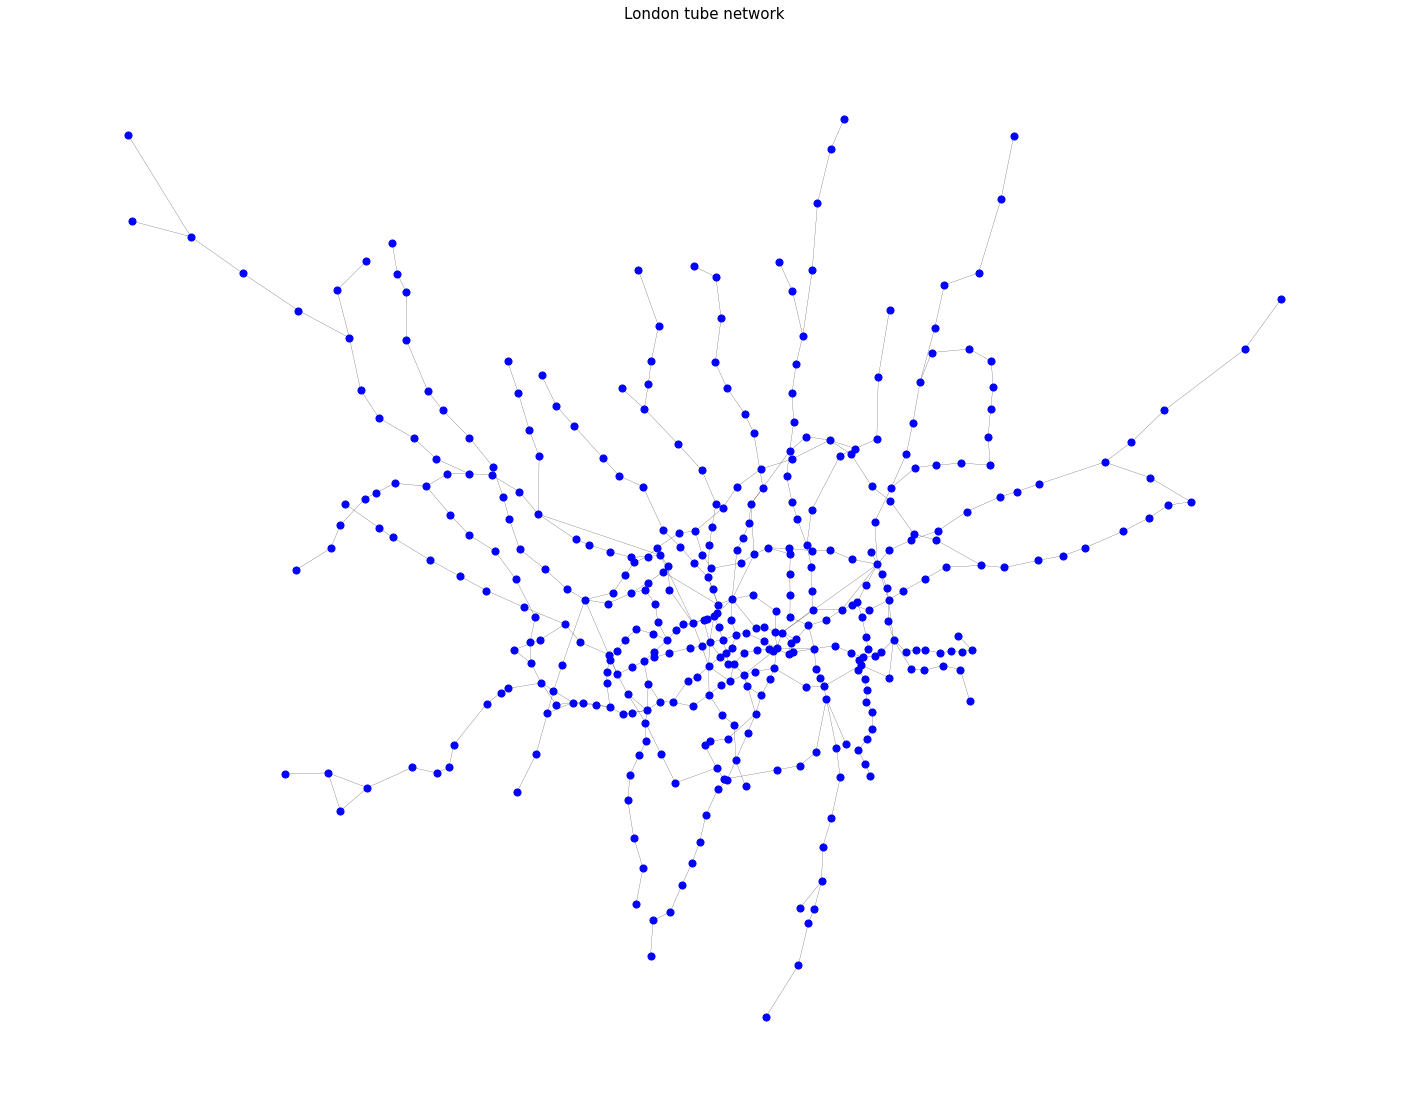

In [4]:
# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G1, 'station_name')

pos = nx.get_node_attributes(G1, 'coords')

nx.draw_networkx_nodes(G1,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G1,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G1,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.savefig(os.path.join('output',"network"))
plt.show()

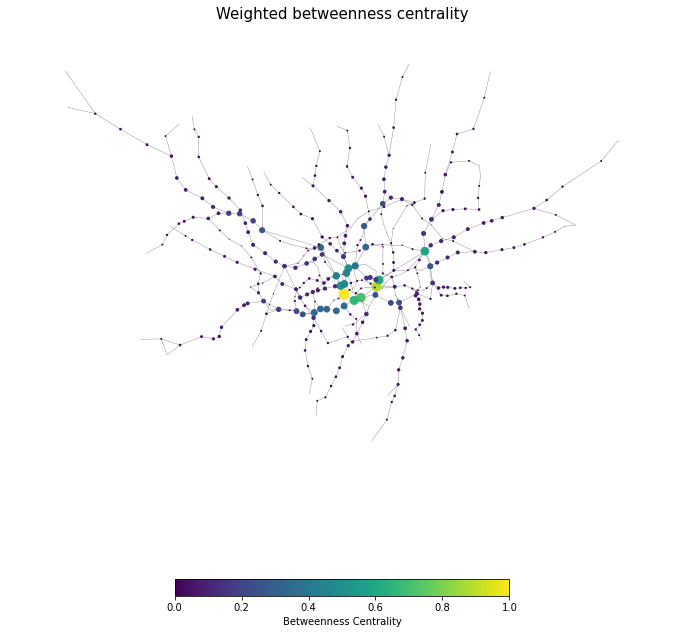

In [5]:
betweenness_w_values=[(i[1]['betweenness_w']) for i in G1.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G1.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G1.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G1, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G1,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Weighted betweenness centrality",fontsize=15)
plt.show()

## Impact measures and strategy

In [6]:
G1 = nx.read_graphml('london.graph')
for node in G1.nodes():
    G1.nodes[node]['coords'] = eval(G1.nodes[node]['coords'])

### Strategy A

In order to find impact measure, we built a testing process to chech each measures

In [7]:
clustering=[]
comm=[]
modu=[]
perfor=[]
area=["All"]
dia=[]                #
component=[]          #
shortest=[]   
for x in range(0,11):
    print("---------------------------------")
    print(f"x= {x}")
    #Let us compute the betweenness centrality for the network, without using weights:
    bet_london_t=nx.betweenness_centrality(G1, normalized=False)
    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G1,bet_london_t,'betweenness_t')

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G1.nodes())
    df['betweenness_t'] = pd.Series(nx.get_node_attributes(G1, 'betweenness_t'))
    
    WS_a_c=nx.average_clustering(G1)
    partitions = algorithms.louvain(G1)
    communities = partitions.communities
    l1=list(G1.nodes)
    components = nx.connected_components(G1)                             
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)                         
    # Create a "subgraph" of the largest component
    Largest_subgraph = G1.subgraph(largest_component)                    
    print(f"the largest component: {Largest_subgraph.number_of_nodes()}")
    WS_a_sp=nx.average_shortest_path_length(Largest_subgraph)            
    diameter = nx.diameter(Largest_subgraph)                             
    print(f"the diameter: {diameter}")                                   
    print(f"the shortest path length: {WS_a_sp}")                        
    print(f"the clustering cofficient: {WS_a_c}")                      
    print(f'number of communities: {len(communities)}')
    print(f'number of connectivity: {nx.node_connectivity(G1)}')
    print(f'modularity of G1: {modularity(G1, communities)}')
    print(f'performance of G1: {performance(G1, communities)}')
    maxbet=[n for n in G1.nodes() if G1.nodes[n]['betweenness_t'] == max(df['betweenness_t'])]
    values_sorted = sorted(bet_london_t.items(), key=itemgetter(1), reverse=True)
    sorted_ten=[e for e,v in values_sorted[:1]]
    print(f"The max betweenness: {sorted_ten}")
    print(f"the len of the node {len(l1)}")
    clustering.append(WS_a_c)
    comm.append(len(communities))
    area.append(sorted_ten[0])
    dia.append(diameter)                                                
    component.append(Largest_subgraph.number_of_nodes())                
    shortest.append(WS_a_sp)                                            
    modu.append(modularity(G1, communities))
    perfor.append(performance(G1, communities))
    G1.remove_nodes_from(sorted_ten)
    print("---------------------------------")
    print("---------------------------------") 
area.pop()
print(f"shortest= {shortest[0]-shortest[-1]}")                        
print(f"component= {component[0]-component[-1]}")                     
print(f"clustering= {clustering[0]-clustering[-1]}")
print(f'comm= {comm[0]-comm[-1]}')
print(f'modularity= {modu[0]-modu[-1]}')
print(f'performance= {perfor[0]-perfor[-1]}')

---------------------------------
x= 0
the largest component: 401
the diameter: 36
the shortest path length: 13.545997506234414
the clustering cofficient: 0.030382377389858693
number of communities: 19
number of connectivity: 1
modularity of G1: 0.8295558235399308
performance of G1: 0.9468827930174564
The max betweenness: ['Stratford']
the len of the node 401
---------------------------------
---------------------------------
---------------------------------
x= 1
the largest component: 379
the diameter: 49
the shortest path length: 14.496447069006436
the clustering cofficient: 0.030625000000000003
number of communities: 21
number of connectivity: 0
modularity of G1: 0.8409450620697545
performance of G1: 0.9519548872180451
The max betweenness: ["King's Cross St. Pancras"]
the len of the node 400
---------------------------------
---------------------------------
---------------------------------
x= 2
the largest component: 378
the diameter: 49
the shortest path length: 15.3101343101343

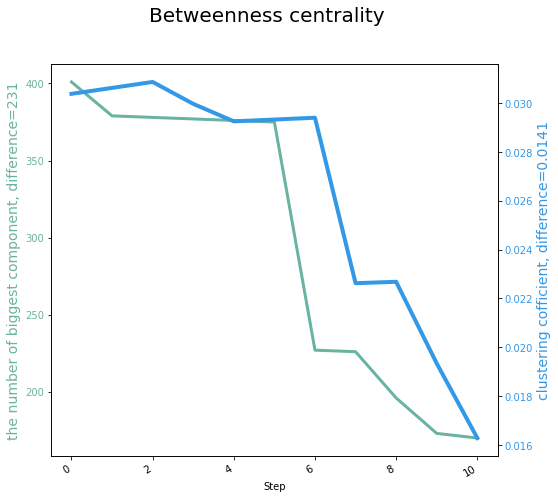

In [8]:
COLOR_TEMPERATURE = "#69b3a2"
COLOR_PRICE = "#3399e6"
x_value=[0,1,2,3,4,5,6,7,8,9,10]
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(x_value,component, color=COLOR_TEMPERATURE, lw=3)
ax2.plot(x_value, clustering, color=COLOR_PRICE, lw=4)

ax1.set_xlabel("Step")
ax1.set_ylabel(f"the number of biggest component, difference={round(component[0]-component[-1],4)}", color=COLOR_TEMPERATURE, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_TEMPERATURE)

ax2.set_ylabel(f"clustering cofficient, difference={round(clustering[0]-clustering[-1],4)}", color=COLOR_PRICE, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_PRICE)
# for x in range(0,11):
#     ax2.annotate(area[x],xy=(x_value[x],clustering[x]), fontsize=7,xytext=(10, 20), textcoords='offset points')
fig.suptitle("Betweenness centrality", fontsize=20)
fig.autofmt_xdate()

### Strategy B

In [9]:
clustering=[]
comm=[]
modu=[]
perfor=[]
dia=[]                
component=[]          
shortest=[]           
G1 = nx.read_graphml('london.graph')
for node in G1.nodes():
    G1.nodes[node]['coords'] = eval(G1.nodes[node]['coords'])

### Topological betweenness centrality:

#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G1)
nx.set_node_attributes(G1,dict(deg_london),'degree')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G1.nodes())
df['degree'] = pd.Series(nx.get_node_attributes(G1, 'degree'))



# Before

WS_a_c=nx.average_clustering(G1)
partitions = algorithms.louvain(G1)
communities = partitions.communities
l1=list(G1.nodes)
print("")
print("Before")
components = nx.connected_components(G1)                             
# Use the max() command to find the largest one:
largest_component = max(components, key=len)                         
# Create a "subgraph" of the largest component
Largest_subgraph = G1.subgraph(largest_component)                    
print(f"the largest component: {Largest_subgraph.number_of_nodes()}")
WS_a_sp=nx.average_shortest_path_length(Largest_subgraph)            
diameter = nx.diameter(Largest_subgraph)                             
print(f"the diameter: {diameter}")                                   
print(f"the shortest path length: {WS_a_sp}")                        
# print(f"the shortest path length: {WS_a_sp}")
print(f"the clustering cofficient: {WS_a_c}")
print(f'number of communities: {len(communities)}')
print(f'modularity of G1: {modularity(G1, communities)}')
print(f'performance of G1: {performance(G1, communities)}')
maxbet=[n for n in G1.nodes() if G1.nodes[n]['degree'] == max(df['degree'])]
print(f"The max betweenness: {maxbet}")
print(f"the len of the node {len(l1)}")
print("---------------------------------")
clustering.append(WS_a_c)
comm.append(len(communities))
modu.append(modularity(G1, communities))
perfor.append(performance(G1, communities))
dia.append(diameter)                                                
component.append(Largest_subgraph.number_of_nodes())                
shortest.append(WS_a_sp)                                            



df_sorted = df.sort_values(["degree"], ascending=False)

# To remove  10 highest values:
# List of nodes:
values_sorted = sorted(deg_london.items(), key=itemgetter(1), reverse=True)
sorted_ten=[e for e,v in values_sorted[:10]]

G1.remove_nodes_from(sorted_ten)
# WS_a_sp=nx.average_shortest_path_length(G1)
WS_a_c=nx.average_clustering(G1)
partitions = algorithms.louvain(G1)
communities = partitions.communities
l2=list(G1.nodes)

print("")
print("After")
components = nx.connected_components(G1)                             
# Use the max() command to find the largest one:
largest_component = max(components, key=len)                         
# Create a "subgraph" of the largest component
Largest_subgraph = G1.subgraph(largest_component)                    
print(f"the largest component: {Largest_subgraph.number_of_nodes()}")
WS_a_sp=nx.average_shortest_path_length(Largest_subgraph)            
diameter = nx.diameter(Largest_subgraph)                             
print(f"the diameter: {diameter}")                                   
print(f"the shortest path length: {WS_a_sp}")                        
# print(f"the shortest path length: {WS_a_sp}")
print(f"the clustering cofficient: {WS_a_c}")
print(f'number of communities: {len(communities)}')
print(f'modularity of G1: {modularity(G1, communities)}')
print(f'performance of G1: {performance(G1, communities)}')
maxbet=[n for n in G1.nodes() if G1.nodes[n]['degree'] == max(df['degree'])]
print(f"The max betweenness: {sorted_ten}")
print(f"the len of the node {len(l2)}")
print("---------------------------------")
clustering.append(WS_a_c)
comm.append(len(communities))
modu.append(modularity(G1, communities))
perfor.append(performance(G1, communities))
dia.append(diameter)                                                
component.append(Largest_subgraph.number_of_nodes())                
shortest.append(WS_a_sp)                                            
print("----------------------------------")
print(f"clustering= {clustering[0]-clustering[-1]}")
print(f'comm= {comm[0]-comm[-1]}')
print(f'modularity= {modu[0]-modu[-1]}')
print(f'performance= {perfor[0]-perfor[-1]}')
print(f"shortest= {shortest[0]-shortest[-1]}")                        
print(f"component= {component[0]-component[-1]}")                     


Before
the largest component: 401
the diameter: 36
the shortest path length: 13.545997506234414
the clustering cofficient: 0.030382377389858693
number of communities: 19
modularity of G1: 0.8314793501735529
performance of G1: 0.9474189526184539
The max betweenness: ['Stratford']
the len of the node 401
---------------------------------

After
the largest component: 346
the diameter: 53
the shortest path length: 18.40477506911284
the clustering cofficient: 0.02378516624040921
number of communities: 26
modularity of G1: 0.8795317770389965
performance of G1: 0.9516951931274182
The max betweenness: ['Stratford', 'Bank and Monument', 'Baker Street', "King's Cross St. Pancras", 'West Ham', 'Canning Town', 'Waterloo', 'Green Park', 'Oxford Circus', 'Liverpool Street']
the len of the node 391
---------------------------------
----------------------------------
clustering= 0.006597211149449483
comm= -7
modularity= -0.04805242686544364
performance= -0.004276240508964357
shortest= -4.85877756287

# Weight network

## centrality measure (betweenness centrality as example)

In [10]:
G1 = nx.read_graphml('london.graph')
for node in G1.nodes():
    G1.nodes[node]['coords'] = eval(G1.nodes[node]['coords'])

inv_weights={(e1, e2):( 0 if weight==0 else round(1./weight,7)) for e1, e2, weight in G1.edges(data='flows')}
nx.set_edge_attributes(G1, inv_weights, 'coverflows')

In [11]:
clustering=[]
comm=[]
modu=[]
perfor=[]
area=["All"]
dia=[]                
component=[]          
shortest=[]           

# G1 = nx.read_graphml('london.graph')
# for node in G1.nodes():
#     G1.nodes[node]['coords'] = eval(G1.nodes[node]['coords'])
for x in range(0,11):
    print("---------------------------------")
    print(f"x= {x}")
    #Let us compute the betweenness centrality for the network, without using weights:
    bet_london_t=nx.betweenness_centrality(G1,weight="coverflows" ,normalized=False)
    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G1,bet_london_t,'betweenness_t')

    # To ataframe using the nodes as the index
    df = pd.DataFrame(index=G1.nodes())
    df['betweenness_t'] = pd.Series(nx.get_node_attributes(G1, 'betweenness_t'))
    # WS_a_sp=nx.average_shortest_path_length(G2)
    WS_a_c=nx.average_clustering(G1)
    partitions = algorithms.louvain(G1)
    communities = partitions.communities
    l1=list(G1.nodes)
    components = nx.connected_components(G1)                             
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)                         
    # Create a "subgraph" of the largest component
    Largest_subgraph = G1.subgraph(largest_component)                    
    print(f"the largest component: {Largest_subgraph.number_of_nodes()}")
    WS_a_sp=nx.average_shortest_path_length(Largest_subgraph)            
    diameter = nx.diameter(Largest_subgraph)                             
    print(f"the diameter: {diameter}")                                   
    print(f"the shortest path length: {WS_a_sp}")                        
    # print(f"the shortest path length: {WS_a_sp}")
    print(f"the clustering cofficient: {WS_a_c}")
    print(f'number of communities: {len(communities)}')
    print(f'modularity of G1: {modularity(G1, communities)}')
    print(f'performance of G1: {performance(G1, communities)}')
    maxbet=[n for n in G1.nodes() if G1.nodes[n]['betweenness_t'] == max(df['betweenness_t'])]
    values_sorted = sorted(bet_london_t.items(), key=itemgetter(1), reverse=True)
    sorted_ten=[e for e,v in values_sorted[:1]]
    print(f"The max betweenness: {sorted_ten}")
    print(f"the len of the node {len(l1)}")
    clustering.append(WS_a_c)
    area.append(sorted_ten[0])
    dia.append(diameter)                                                
    component.append(Largest_subgraph.number_of_nodes())                
    shortest.append(WS_a_sp)                                           
    comm.append(len(communities))
    modu.append(modularity(G1, communities))
    perfor.append(performance(G1, communities))
    G1.remove_nodes_from(sorted_ten)
    print("---------------------------------")
    print("---------------------------------") 
area.pop()
print(f"shortest= {shortest[0]-shortest[-1]}")                        
print(f"component= {component[0]-component[-1]}")                     
print(f"clustering= {clustering[0]-clustering[-1]}")
print(f'comm= {comm[0]-comm[-1]}')
print(f'modularity= {modu[0]-modu[-1]}')
print(f'performance= {perfor[0]-perfor[-1]}')

---------------------------------
x= 0
the largest component: 401
the diameter: 36
the shortest path length: 13.545997506234414
the clustering cofficient: 0.030382377389858693
number of communities: 19
modularity of G1: 0.8287304724218094
performance of G1: 0.949077306733167
The max betweenness: ['Green Park']
the len of the node 401
---------------------------------
---------------------------------
---------------------------------
x= 1
the largest component: 400
the diameter: 36
the shortest path length: 13.82453634085213
the clustering cofficient: 0.02979166666666667
number of communities: 18
modularity of G1: 0.832277751375158
performance of G1: 0.9461654135338345
The max betweenness: ['Bank and Monument']
the len of the node 400
---------------------------------
---------------------------------
---------------------------------
x= 2
the largest component: 399
the diameter: 38
the shortest path length: 14.382728177226987
the clustering cofficient: 0.02927556987707364
number of co

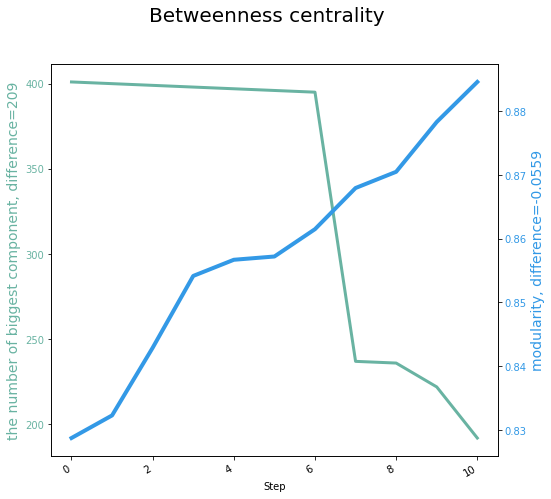

In [12]:
COLOR_TEMPERATURE = "#69b3a2"
COLOR_PRICE = "#3399e6"
x_value=[0,1,2,3,4,5,6,7,8,9,10]
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(x_value,component, color=COLOR_TEMPERATURE, lw=3)
ax2.plot(x_value, modu, color=COLOR_PRICE, lw=4)

ax1.set_xlabel("Step")
ax1.set_ylabel(f"the number of biggest component, difference={round(component[0]-component[-1],4)}", color=COLOR_TEMPERATURE, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_TEMPERATURE)

ax2.set_ylabel(f"modularity, difference={round(modu[0]-modu[-1],4)}", color=COLOR_PRICE, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_PRICE)
# for x in range(0,11):
#     ax1.annotate(area[x],xy=(x_value[x],component[x]), xytext=(10, -10), textcoords='offset points')
fig.suptitle("Betweenness centrality", fontsize=20)
fig.autofmt_xdate()